**1. Import external libraries**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
filepath = '/content/drive/Othercomputers/내 MacBook Pro/inpainting-transformer/NoisyNMIST'
sys.path.append(filepath)

**3. Load the data (and visualize images to help understanding)**

In [125]:
from nmist_better import RandomNoise, test, save_image, prepare_data, Origin_Model, show_image, main, train

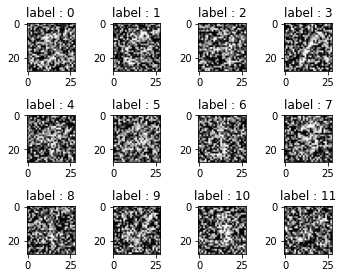

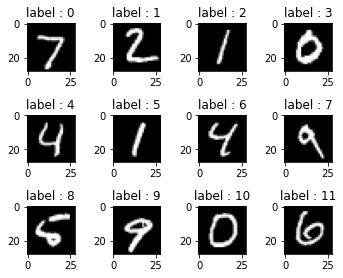

In [126]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
matplotlib.use('TkAgg')

batch = 16
lr = 1e-2
epochs = 10
log_interval = 100

train_set, test_set = prepare_data()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000)



show_image(train_set)
show_image(test_set)

In [127]:
class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1):
    super(DnCNN, self).__init__()
    layers = [
        nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                  padding=1, bias=False),
        nn.ReLU(inplace=True)
    ]
    for _ in range(depth-2):
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                padding=1, bias=False))
        layers.append(nn.BatchNorm2d(n_filters))
        layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                            padding=1, bias=False))
    self.dncnn = nn.Sequential(*layers)

  def forward(self, x):
    out = self.dncnn(x)
    return out

In [128]:


class MLP_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.mlp(x)
        return F.log_softmax(x, dim=1)


In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dncnn = DnCNN().to(device)
model = MLP_Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()


for epoch in range(1, epochs):
  dncnn.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    target = model(data)

    optimizer.zero_grad()
    output = dncnn(data)
    loss = loss_func(output, data)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Epoch {} [{}/{}]: Loss{:6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset), loss))
        
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    data = dncnn(data)

    optimizer.zero_grad()
    output = model(data)
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Epoch {} [{}/{}]: Loss{:6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset), loss))
            
    # train(model, train_loader, loss_func, optimizer, epoch, log_interval)
    test(model, train_loader, loss_func)
  

Epoch 1 [0/60000]: Loss1.581030
Epoch 1 [1600/60000]: Loss1.604061
Epoch 1 [3200/60000]: Loss1.611910
Epoch 1 [4800/60000]: Loss1.629054
Epoch 1 [6400/60000]: Loss1.666870
Epoch 1 [8000/60000]: Loss1.657206
Epoch 1 [9600/60000]: Loss1.630484
Epoch 1 [11200/60000]: Loss1.633340
Epoch 1 [12800/60000]: Loss1.592965
Epoch 1 [14400/60000]: Loss1.658003
Epoch 1 [16000/60000]: Loss1.585511
Epoch 1 [17600/60000]: Loss1.619792
Epoch 1 [19200/60000]: Loss1.675685
Epoch 1 [20800/60000]: Loss1.653242
Epoch 1 [22400/60000]: Loss1.651219
Epoch 1 [24000/60000]: Loss1.647812
Epoch 1 [25600/60000]: Loss1.614825
Epoch 1 [27200/60000]: Loss1.650830
Epoch 1 [28800/60000]: Loss1.645599
Epoch 1 [30400/60000]: Loss1.676551
Epoch 1 [32000/60000]: Loss1.653087
Epoch 1 [33600/60000]: Loss1.605228
Epoch 1 [35200/60000]: Loss1.600289
Epoch 1 [36800/60000]: Loss1.651108
Epoch 1 [38400/60000]: Loss1.635497
Epoch 1 [40000/60000]: Loss1.632286
Epoch 1 [41600/60000]: Loss1.681536
Epoch 1 [43200/60000]: Loss1.659700
Ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored